# ImageNet Mini 1000 Torch MobileNet


In [1]:
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Data Setting

In [3]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            labels+=[label]
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]            

In [4]:
class_names=sorted(set(labels))
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))    

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878', 'n01530575', 'n01531178', 'n01532829', 'n01534433', 'n01537544', 'n01558993', 'n01560419', 'n01580077', 'n01582220', 'n01592084', 'n01601694', 'n01608432', 'n01614925', 'n01616318', 'n01622779', 'n01629819', 'n01630670', 'n01631663', 'n01632458', 'n01632777', 'n01641577', 'n01644373', 'n01644900', 'n01664065', 'n01665541', 'n01667114', 'n01667778', 'n01669191', 'n01675722', 'n01677366', 'n01682714', 'n01685808', 'n01687978', 'n01688243', 'n01689811', 'n01692333', 'n01693334', 'n01694178', 'n01695060', 'n01697457', 'n01698640', 'n01704323', 'n01728572', 'n01728920', 'n01729322', 'n01729977', 'n01734418', 'n01735189', 'n01737021', 'n01739381', 'n01740131', 'n01742172', 'n01744401', 'n01748264', 'n01749939', 'n01751748', 'n01753488', 'n01755581', 'n01756291', 'n01768244', 'n01770081', 'n01770393', 'n01773157', 'n01773549', 'n01773797', 'n01774384', 'n01774750'

In [5]:
df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

tdf=pd.DataFrame(columns=['path','label'])
tdf['path']=tpaths
tdf['label']=tlabels
tdf['label']=tdf['label'].map(normal_mapping)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        path = self.dataframe.loc[index, 'path']
        label = self.dataframe.loc[index, 'label']
        image = Image.open(path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        image = transform(image)
        return image, label

In [7]:
train_ds=CustomDataset(df)
test_ds=CustomDataset(tdf)

In [8]:
train_loader=DataLoader(train_ds,batch_size=32,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=32)

# Check Images and Labels

In [9]:
for images, labels in train_loader:
    break

im=make_grid(images,nrow=16)

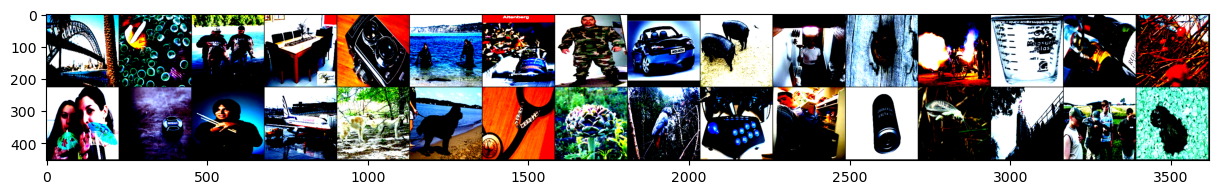

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [11]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

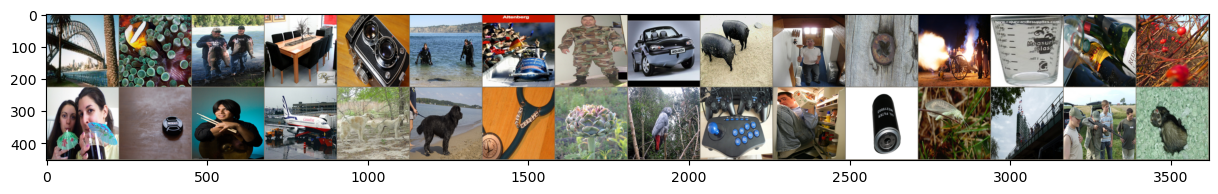

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Model

In [13]:
torch.manual_seed(42)

In [14]:
model= models.mobilenet_v2(pretrained=True)
#model= models.alexnet(pretrained=True)

for param in model.parameters():
    param.requires_grad=False

model.classifier=nn.Sequential( nn.Linear(1280,1024),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(1024,len(class_names)),
                                nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:03<00:00, 4.02MB/s]


In [ ]:
#model

In [15]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(model)

 1310720
    1024
 1024000
    1000
________
 2336744


In [16]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [17]:
epochs=10

In [18]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_train = torch.tensor(y_train) ###added
        y_pred=model(X_train)
        loss=criterion(y_pred,y_train)       
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
                  
            y_val=model(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')        

epoch:  0  batch:  200 [  2000/8000]  loss: 6.78646231  accuracy:   3.000%
epoch:  0  batch:  400 [  4000/8000]  loss: 6.38617659  accuracy:   4.475%
epoch:  0  batch:  600 [  6000/8000]  loss: 6.02799368  accuracy:   5.933%
epoch:  0  batch:  800 [  8000/8000]  loss: 5.61475325  accuracy:   7.750%
epoch:  0  batch: 1000 [ 10000/8000]  loss: 5.21413231  accuracy:   9.450%


KeyboardInterrupt: 

# Prediction

In [ ]:
device = torch.device("cpu")   #"cuda:0"

In [ ]:
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))